In [1]:
import pandas as pd
import numpy as np

from data.data_dictionary import var_map, chron_conditions

chroncon_file = 'data/Assignment4_ChronicConditions-2.csv'
df = pd.DataFrame.from_csv(chroncon_file, encoding='latin1').reset_index()

display(df.head(2))
print(df.shape)
print(chron_conditions)

,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,CC_ALZHDMTA,CC_CANCER,CC_CHF,CC_CHRNKIDN,CC_COPD,CC_DEPRESSN,CC_DIABETES,CC_ISCHMCHT,...,BENE_COUNT_PC_LT_12,AVE_MO_EN_PC_LT_12,BENE_COUNT_PC_EQ_12,BENE_COUNT_PD_LT_12,AVE_MO_EN_PD_LT_12,AVE_PDE_CST_PD_LT_12,AVE_PDE_PD_LT_12,BENE_COUNT_PD_EQ_12,AVE_PDE_CST_PD_EQ_12,AVE_PDE_PD_EQ_12
0,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,7230.0,49.877
1,1,1,NaN,NaN,0,0,NaN,NaN,0,0,...,NaN,NaN,NaN,42.0,5.952,2165.0,24.81,203.0,7163.0,73.404


(22003, 55)
['CC_NONE', 'CC_ALZHDMTA', 'CC_CANCER', 'CC_CHF', 'CC_CHRNKIDN', 'CC_COPD', 'CC_DEPRESSN', 'CC_DIABETES', 'CC_ISCHMCHT', 'CC_OSTEOPRS', 'CC_RA_OA', 'CC_STRKETIA']


In [2]:
# Columns for total spent for each profile

df['A_tot_pay']      = df['BENE_COUNT_PA_EQ_12'] * df['AVE_PA_PAY_PA_EQ_12']
df['A_tot_IP']       = df['BENE_COUNT_PA_EQ_12'] * df['AVE_IP_PAY_PA_EQ_12']
df['A_tot_IP_adm']   = df['BENE_COUNT_PA_EQ_12'] * df['AVE_IP_ADM_PA_EQ_12']
df['A_tot_SNF']      = df['BENE_COUNT_PA_EQ_12'] * df['AVE_SNF_PAY_PA_EQ_12']
df['A_tot_SNF_days'] = df['BENE_COUNT_PA_EQ_12'] * df['AVE_SNF_DAYS_PA_EQ_12']
df['A_tot_other']    = df['BENE_COUNT_PA_EQ_12'] * df['AVE_OTH_PAY_PA_EQ_12']

df['B_tot_pay']    = df['BENE_COUNT_PB_EQ_12'] * df['AVE_PB_PAY_PB_EQ_12']
df['B_tot_CA']     = df['BENE_COUNT_PB_EQ_12'] * df['AVE_CA_PAY_PB_EQ_12']
df['B_tot_CA_vis'] = df['BENE_COUNT_PB_EQ_12'] * df['AVE_CA_VST_PB_EQ_12']
df['B_tot_OP']     = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OP_PAY_PB_EQ_12']
df['B_tot_OP_vis'] = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OP_VST_PB_EQ_12']
df['B_tot_other']  = df['BENE_COUNT_PB_EQ_12'] * df['AVE_OTH_PAY_PB_EQ_12']

df['D_tot_cost'] = df['BENE_COUNT_PD_EQ_12'] * df['AVE_PDE_CST_PD_EQ_12']
df['D_tot_rx']   = df['BENE_COUNT_PD_EQ_12'] * df['AVE_PDE_PD_EQ_12']


# Column for people with no conditions
df['CC_NONE'] = 0.
df.loc[
    (df.CC_ALZHDMTA == 0.) & 
    (df.CC_CANCER == 0.)   & 
    (df.CC_CHF == 0.)      & 
    (df.CC_CHRNKIDN == 0.) & 
    (df.CC_COPD == 0.)     & 
    (df.CC_DEPRESSN == 0.) & 
    (df.CC_DIABETES == 0.) & 
    (df.CC_ISCHMCHT == 0.) & 
    (df.CC_OSTEOPRS == 0.) & 
    (df.CC_RA_OA == 0.)    & 
    (df.CC_STRKETIA == 0.) ,
    'CC_NONE'] = 1.

In [3]:
## _____________________________________________________________________________
def get_df(df, chroncon, excl=True):
    
    if chroncon == 'CC_NONE':
        df_ = df[df[chroncon] == 1.]
        return df_
        
        
    # only keep rows where condition IS present - also drops suppressed
    df_ = df[df[chroncon] == 1.]

    if excl:
        # drop rows where other conditions ARE present
        for xc in chron_conditions:
            if xc in [chroncon, 'CC_NONE']: continue
            df_ = df_.drop(df_[df_[xc] == 1.].index)

    return df_

In [4]:
## _____________________________________________________________________________
def build_numbers(df, excl=True):

    numbers = { x : {} for x in chron_conditions }

    for x in chron_conditions:
        df_ = get_df(df, x, excl)


        numbers[x]['part_A'] = {
            'num_benes'    : 0,
            'tot_pay'      : 0.,
            'avg_pay'      : 0.,
            'avg_IP'       : 0.,
            'avg_IP_adm'   : 0.,
            'avg_SNF'      : 0.,
            'avg_SNF_days' : 0.,
            'avg_other'    : 0.,
        }       

        numbers[x]['part_B'] = {
            'num_benes'   : 0,
            'tot_pay'     : 0.,
            'avg_pay'     : 0.,
            'avg_CA'      : 0.,
            'avg_CA_vis'  : 0.,
            'avg_OP'      : 0.,
            'avg_OP_vis'  : 0.,
            'avg_other'   : 0.,
        }

        numbers[x]['part_C'] = {
            'num_benes' : 0,
        }

        numbers[x]['part_D'] = {
            'num_benes'   : 0,
            'tot_cost'    : 0.,
            'avg_num_rx'  : 0.,
            'avg_rx_cost' : 0.,
        }


        # Part A
        #############################
        # Num benes with this condition
        numbers[x]['part_A']['num_benes'] = df_['BENE_COUNT_PA_EQ_12'].sum()
        num_benes_part_A.append(numbers[x]['part_A']['num_benes'])

        # Total spent for people with this condition
        numbers[x]['part_A']['tot_pay'] = df_['A_tot_pay'].sum()
        tot_paid_part_A.append(numbers[x]['part_A']['tot_pay'])

        # Average spent per person with this condition
        numbers[x]['part_A']['avg_pay'] = df_['A_tot_pay'].sum() \
                                       / numbers[x]['part_A']['num_benes']
        avg_paid_part_A.append(numbers[x]['part_A']['avg_pay'])

        # Average paid for InPatient services per person with this condition
        numbers[x]['part_A']['avg_IP']  = df_['A_tot_IP'].sum() \
                                       / numbers[x]['part_A']['num_benes']
        avg_IP_paid_part_A.append(numbers[x]['part_A']['avg_IP'])

        # Average InPatient admissions per person with this condition
        numbers[x]['part_A']['avg_IP_adm'] = df_['A_tot_IP_adm'].sum() \
                                       / numbers[x]['part_A']['num_benes']
        avg_IP_adms_part_A.append(numbers[x]['part_A']['avg_IP_adm'])

        # Average paid for Skilled Nursing Facility services per person with this condition
        numbers[x]['part_A']['avg_SNF'] = df_['A_tot_SNF'].sum() \
                                       / numbers[x]['part_A']['num_benes']
        avg_SNF_paid_part_A.append(numbers[x]['part_A']['avg_SNF'])

        # Average Skilled Nursing Facility covered days per person with this condition
        numbers[x]['part_A']['avg_SNF_days'] = df_['A_tot_SNF_days'].sum() \
                                       / numbers[x]['part_A']['num_benes']
        avg_SNF_days_part_A.append(numbers[x]['part_A']['avg_SNF_days'])

        # Average other spending per person with this condition
        numbers[x]['part_A']['avg_other'] = df_['A_tot_other'].sum() \
                                       / numbers[x]['part_A']['num_benes']



        # Part B
        #############################
        # Num benes with this condition
        numbers[x]['part_B']['num_benes'] = df_['BENE_COUNT_PB_EQ_12'].sum()
        num_benes_part_B.append(numbers[x]['part_B']['num_benes'])

        # Total spent for people with this condition
        numbers[x]['part_B']['tot_pay'] = df_['B_tot_pay'].sum()
        tot_paid_part_B.append(numbers[x]['part_B']['tot_pay'])

        # Average spent per person with this condition
        numbers[x]['part_B']['avg_pay'] = df_['B_tot_pay'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        avg_paid_part_B.append(numbers[x]['part_B']['avg_pay'])
        
        # Average spent for Carrier/Physician visits per person with this condition
        numbers[x]['part_B']['avg_CA'] = df_['B_tot_CA'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        avg_CA_paid_part_B.append(numbers[x]['part_B']['avg_CA'])

        # Average Carrier/Physician visits per person with this condition
        numbers[x]['part_B']['avg_CA_vis'] = df_['B_tot_CA_vis'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        avg_CA_vis_part_B.append(numbers[x]['part_B']['avg_CA_vis'])

        # Average spent for OutPatient services per person with this condition
        numbers[x]['part_B']['avg_OP'] = df_['B_tot_OP'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        avg_OP_paid_part_B.append(numbers[x]['part_B']['avg_OP'])

        # Average OutPatient visits per person with this condition
        numbers[x]['part_B']['avg_OP_vis'] = df_['B_tot_OP_vis'].sum() \
                                          / numbers[x]['part_B']['num_benes']
        avg_OP_vis_part_B.append(numbers[x]['part_B']['avg_OP_vis'])

        # Average other spending per person with this condition
        numbers[x]['part_B']['avg_other'] = df_['B_tot_other'].sum() \
                                          / numbers[x]['part_B']['num_benes']


        # Part C
        #############################
        # Num benes with this condition
        numbers[x]['part_C']['num_benes'] = df_['BENE_COUNT_PC_EQ_12'].sum()
        num_benes_part_C.append(numbers[x]['part_C']['num_benes'])


        # Part D
        #############################
        # Num benes with this condition
        numbers[x]['part_D']['num_benes'] = df_['BENE_COUNT_PD_EQ_12'].sum()
        num_benes_part_D.append(numbers[x]['part_D']['num_benes'])

        # Total spent for people with this condition
        numbers[x]['part_D']['tot_cost'] = df_['D_tot_cost'].sum()
        tot_paid_part_D.append(numbers[x]['part_D']['tot_cost'])
    
        # Average number of RX per person with this condition
        numbers[x]['part_D']['avg_num_rx']  = df_['D_tot_rx'].sum() \
                                      / numbers[x]['part_D']['num_benes']

        # Average RX cost per person with this condition
        numbers[x]['part_D']['avg_rx_cost'] = df_['D_tot_cost'].sum() \
                                          / numbers[x]['part_D']['num_benes']
        avg_paid_part_D.append(numbers[x]['part_D']['avg_rx_cost'])



    del df_
    return numbers

In [5]:
## _____________________________________________________________________________
def print_numbers(chroncon, numbers):

    print(var_map[chroncon] + ':')
    
    n = numbers[chroncon]
    
    print('   ', 'Part A=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_A']['num_benes'])))
    print('       ', 'Total spent for people with this condition:',
           str(n['part_A']['tot_pay']))
    print('       ', 'Average spent per person with this condition:',
           str((n['part_A']['avg_pay'])))
    print('       ', 'Average for InPatient services per person with this condition:',
           str((n['part_A']['avg_IP'])))
    print('       ', 'Average InPatient admissions per person with this condition:',
           str((n['part_A']['avg_IP_adm'])))
    print('       ', 'Average for Skilled Nursing Facility services per person with this condition:',
           str((n['part_A']['avg_SNF'])))
    print('       ', 'Average Skilled Nursing Facility covered days per person with this condition:',
           str((n['part_A']['avg_SNF_days'])))
    print('       ', 'Average other spending per person with this condition:',
           str((n['part_A']['avg_other'])))
    

    print('\n   ', 'Part B=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_B']['num_benes'])))
    print('       ', 'Total spent for people with this condition:',
           str(n['part_B']['tot_pay']))
    print('       ', 'Average spent per person with this condition:',
           str(n['part_B']['avg_pay']))
    print('       ', 'Average for Carrier/Physician visits per person with this condition:',
           str(n['part_B']['avg_CA']))
    print('       ', 'Average Carrier/Physician visits per person with this condition:',
           str(n['part_B']['avg_CA_vis']))
    print('       ', 'Average for OutPatient services per person with this condition:',
           str(n['part_B']['avg_OP']))
    print('       ', 'Average OutPatient visits per person with this condition:',
           str(n['part_B']['avg_OP_vis']))
    print('       ', 'Average other spending per person with this condition:',
           str(n['part_B']['avg_other']))
    
    print('\n   ', 'Part C=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_C']['num_benes'])))
    
    print('\n   ', 'Part D=12:')
    print('       ', 'Num benes with this condition:',
           str(int(n['part_D']['num_benes'])))
    
    print('       ', 'Total spent on RX for people with this condition:',
           str(n['part_D']['tot_cost']))
    
    print('       ', 'Average number of RX per person with this condition:',
           str(n['part_D']['avg_num_rx']))
    
    print('       ', 'Average RX cost per person with this condition:',
           str(n['part_D']['avg_rx_cost']))
    
    print('\n\n\n')

In [6]:
num_benes_part_A = []
num_benes_part_B = []
num_benes_part_C = []
num_benes_part_D = []

tot_paid_part_A = []
tot_paid_part_B = []
tot_paid_part_D = []

avg_paid_part_A = []
avg_paid_part_B = []
avg_paid_part_D = []

avg_IP_adms_part_A  = []
avg_IP_paid_part_A  = []

avg_SNF_days_part_A = []
avg_SNF_paid_part_A = []

avg_CA_vis_part_B  = []
avg_CA_paid_part_B = []

avg_OP_vis_part_B  = []
avg_OP_paid_part_B = []



numbers1 = build_numbers(df)#, excl=False)
for x in [chron_conditions[3]]:
    print_numbers(x, numbers1)

Heart Failure:
    Part A=12:
        Num benes with this condition: 202733
        Total spent for people with this condition: 529369217.0
        Average spent per person with this condition: 2611.1645218094736
        Average for InPatient services per person with this condition: 1922.7980151233396
        Average InPatient admissions per person with this condition: 0.2089333458292434
        Average for Skilled Nursing Facility services per person with this condition: 330.65833386769793
        Average Skilled Nursing Facility covered days per person with this condition: 0.8092076869577225
        Average other spending per person with this condition: 355.37684047491035

    Part B=12:
        Num benes with this condition: 198749
        Total spent for people with this condition: 674409658.0
        Average spent per person with this condition: 3393.2732139532777
        Average for Carrier/Physician visits per person with this condition: 1840.2378477375987
        Average Carrie

## Plots

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-muted')
plt.rc('axes', axisbelow=True)
%matplotlib inline

con_labels = [ var_map[c] for c in chron_conditions ]
idx = np.arange(len(con_labels))

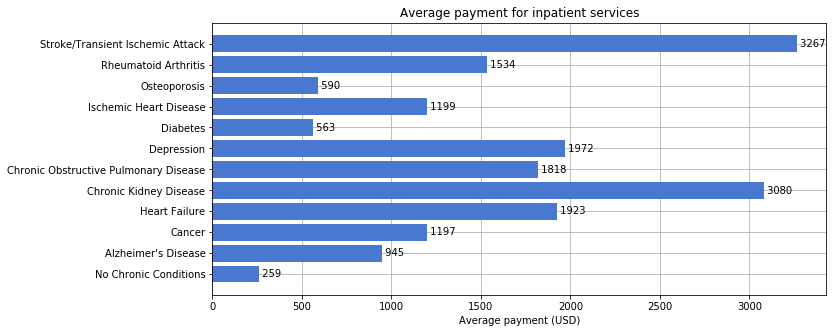

In [8]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_IP_paid_part_A)
plt.title('Average payment for inpatient services')
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_IP_paid_part_A[i]
    plt.text(v, i, ' ' + '{0:.0f}'.format(v), va='center')
plt.show();

#### Total amount spent by condition and program

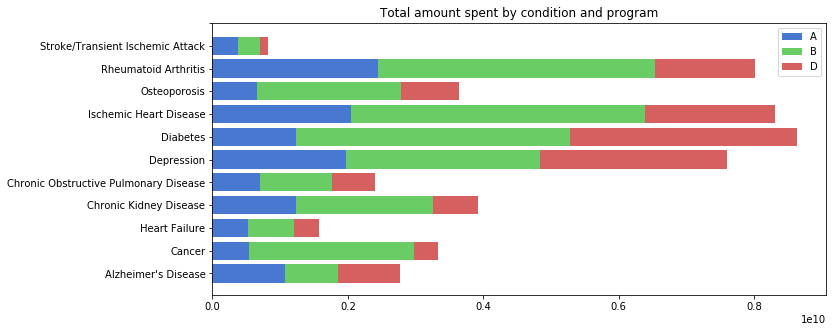

In [9]:
_ = plt.figure(figsize=(11,5))

left_A = None
left_B = tot_paid_part_A[1:]
left_D = [sum(x) for x in zip(tot_paid_part_A[1:], tot_paid_part_B[1:])]

p1 = plt.barh(idx[:-1], tot_paid_part_A[1:])
p2 = plt.barh(idx[:-1], tot_paid_part_B[1:], left=left_B)
p4 = plt.barh(idx[:-1], tot_paid_part_D[1:], left=left_D)

plt.title('Total amount spent by condition and program')
plt.yticks(idx, con_labels[1:])
plt.legend((p1[0], p2[0], p4[0]), ('A', 'B', 'D'))
plt.show();

#### Average amount spent per beneficiary by condition and program

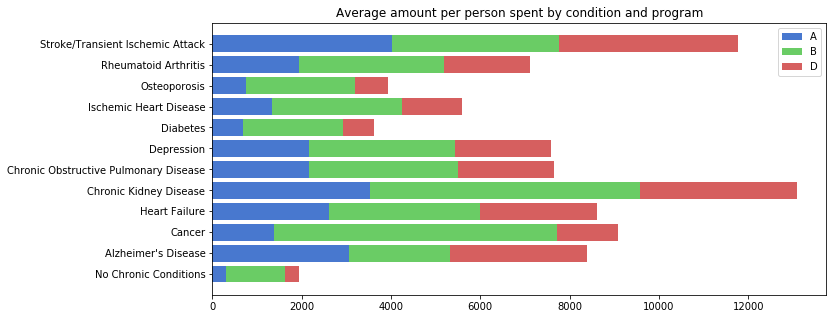

In [10]:
_ = plt.figure(figsize=(11,5))

left_A = None
left_B = avg_paid_part_A
left_D = [sum(x) for x in zip(avg_paid_part_A, avg_paid_part_B)]


p1 = plt.barh(idx, avg_paid_part_A)
p2 = plt.barh(idx, avg_paid_part_B, left=left_B)
p4 = plt.barh(idx, avg_paid_part_A, left=left_D)

plt.title('Average amount per person spent by condition and program')
plt.yticks(idx, con_labels)
plt.legend((p1[0], p2[0], p4[0]), ('A', 'B', 'D'))
plt.show();

### MEDICARE PART A

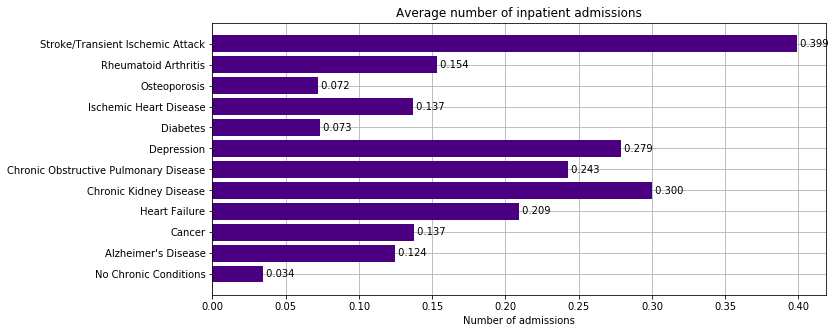

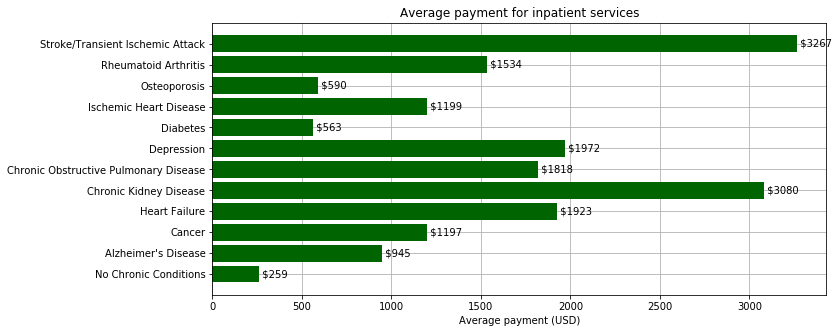

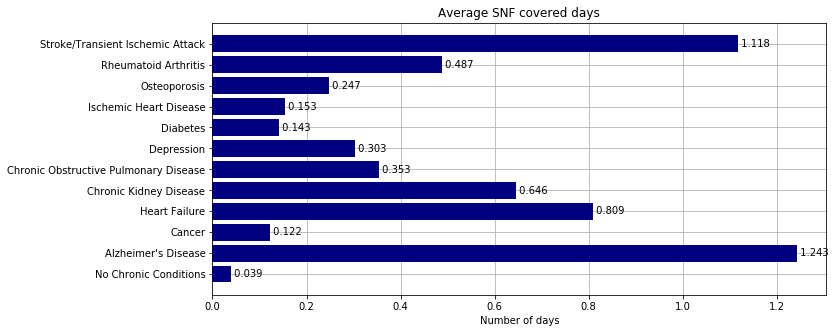

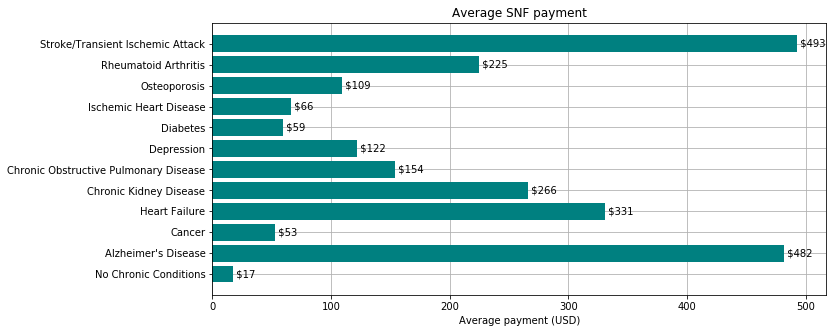

In [13]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_IP_adms_part_A, color='indigo');
plt.title('Average number of inpatient admissions')
ax.grid();
plt.xlabel('Number of admissions')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_IP_adms_part_A[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_IP_paid_part_A, color='darkgreen')
plt.title('Average payment for inpatient services')
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_IP_paid_part_A[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_SNF_days_part_A, color='navy')
plt.title('Average SNF covered days')
ax.grid();
plt.xlabel('Number of days')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_SNF_days_part_A[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_SNF_paid_part_A, color='teal')
plt.title('Average SNF payment')
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_SNF_paid_part_A[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')#, fontweight='bold')
plt.show();

### MEDICARE PART B

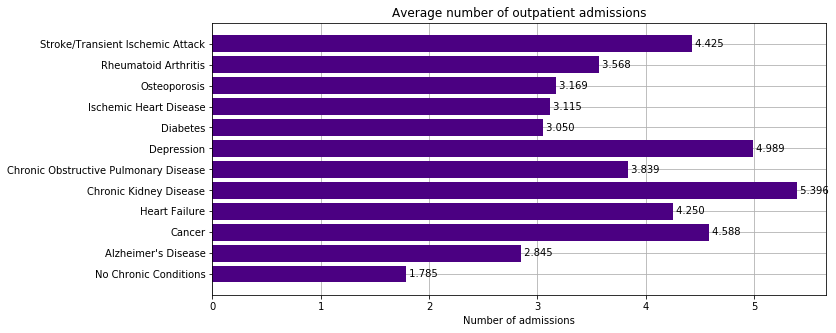

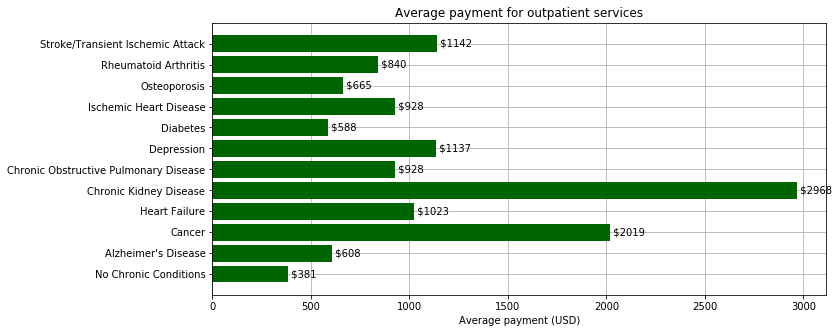

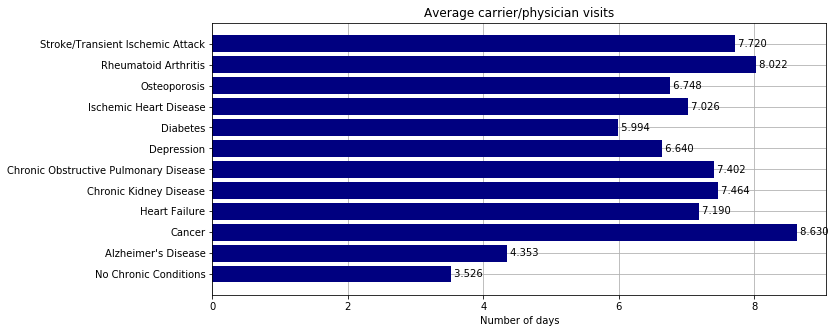

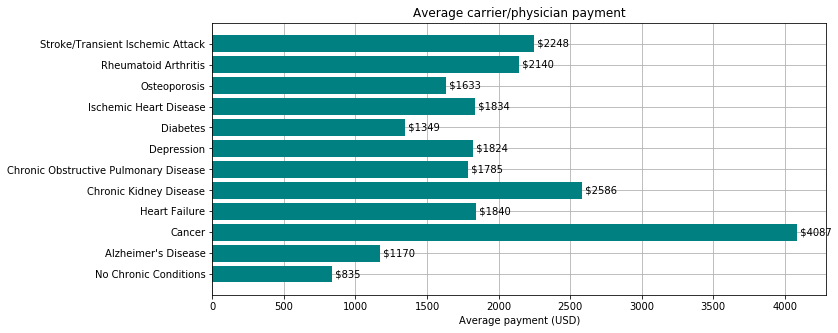

In [14]:
fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_OP_vis_part_B, color='indigo');
plt.title('Average number of outpatient admissions')
ax.grid();
plt.xlabel('Number of admissions')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_OP_vis_part_B[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_OP_paid_part_B, color='darkgreen')
plt.title('Average payment for outpatient services')
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_OP_paid_part_B[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_CA_vis_part_B, color='navy')
plt.title('Average carrier/physician visits')
ax.grid();
plt.xlabel('Number of days')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_CA_vis_part_B[i]
    plt.text(v, i, ' ' + '{0:.3f}'.format(v), va='center')
plt.show();

fig, ax = plt.subplots(1,1,figsize=(11,5));
p1 = plt.barh(idx, avg_CA_paid_part_B, color='teal')
plt.title('Average carrier/physician payment')
ax.grid();
plt.xlabel('Average payment (USD)')
plt.yticks(idx, con_labels)
for i,v in enumerate(chron_conditions):
    v = avg_CA_paid_part_B[i]
    plt.text(v, i, ' ' + '${0:.0f}'.format(v), va='center')#, fontweight='bold')
plt.show();